In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def early_prediction_score(y_true, y_pred, alpha=0.5):
    errors = y_pred - y_true
    # Heavier penalty for late predictions
    weights = np.where(errors < 0, alpha, 1)
    return np.mean(weights * errors**2)

In [3]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        # '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:35<00:00, 390.76it/s]
INFO:root:Read in 57.81956434249878 seconds


In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


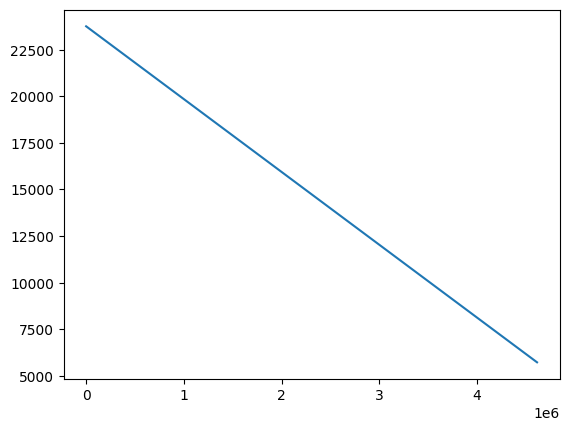

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [12]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [45]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for unit, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
    def create_overlapping_windows(signal, window_size=2560, overlap=0.75):
        step = int(window_size * (1 - overlap))
        return np.lib.stride_tricks.sliding_window_view(
            signal, window_shape=window_size, axis=0
        )[::step]
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['1_1'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_3'],
)

val_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_4'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [46]:
len(train_dataset)

5604

In [134]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extractor
        self.features = torch.nn.Sequential(
            # Layer 1: Wide receptive field
            torch.nn.Conv1d(2, 64, kernel_size=51, padding=25),  # (B, 2, 2560) -> (B, 64, 2560)
            torch.nn.BatchNorm1d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 64, 1278)
            
            # Layer 2: Mid-range features
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),  # -> (B, 128, 1278)
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 128, 637)
            
            # Layer 3: Local features
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),  # -> (B, 256, 637)
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.AdaptiveAvgPool1d(1)  # -> (B, 256, 1)
        )
        
        # Regressor (fixed input dim)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),  # Better for regression
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1),
            # Removed Sigmoid() for regression
        )

        # self.fc = torch.nn.Linear(128, 1)

        # with torch.no_grad():
        #     self.fc.weight.data = -torch.abs(self.fc.weight.data)
        #     self.fc.bias.data.fill_(1.0)  # Start predictions near 1.0
    
    def forward(self, x):
        # Input: (B, 2560, 2)
        x = x.permute(0, 2, 1)  # -> (B, 2, 2560)
        x = self.features(x)     # -> (B, 256, 1)
        x = x.squeeze(-1)        # -> (B, 256)
        x = self.regressor(x)  # -> (B,)
        return x

model = BearingCNN()

print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=

In [135]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = weighted_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        # scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [ ]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 30)

train_results

100%|██████████| 176/176 [00:03<00:00, 48.32it/s]


Epoch 1: Train Loss 0.0414, Train R2 = 0.636, Train RMSE = 0.174, Train MSE = 0.030, Train MAE = 0.102


Epoch 1 Val: 100%|██████████| 72/72 [00:00<00:00, 190.04it/s]


Epoch 1: Val Loss 0.6364, Val R2 = -3.105, Val RMSE = 0.568, Val MSE = 0.322, Val MAE = 0.494


100%|██████████| 176/176 [00:03<00:00, 48.53it/s]


Epoch 2: Train Loss 0.0570, Train R2 = 0.547, Train RMSE = 0.194, Train MSE = 0.038, Train MAE = 0.112


Epoch 2 Val: 100%|██████████| 72/72 [00:00<00:00, 192.37it/s]


Epoch 2: Val Loss 0.6734, Val R2 = -3.344, Val RMSE = 0.584, Val MSE = 0.341, Val MAE = 0.511


100%|██████████| 176/176 [00:03<00:00, 48.33it/s]


Epoch 3: Train Loss 0.0629, Train R2 = 0.528, Train RMSE = 0.198, Train MSE = 0.039, Train MAE = 0.117


Epoch 3 Val: 100%|██████████| 72/72 [00:00<00:00, 193.05it/s]


Epoch 3: Val Loss 0.7584, Val R2 = -3.892, Val RMSE = 0.620, Val MSE = 0.384, Val MAE = 0.550


100%|██████████| 176/176 [00:03<00:00, 48.22it/s]


Epoch 4: Train Loss 0.0626, Train R2 = 0.539, Train RMSE = 0.196, Train MSE = 0.038, Train MAE = 0.115


Epoch 4 Val: 100%|██████████| 72/72 [00:00<00:00, 190.46it/s]


Epoch 4: Val Loss 0.6657, Val R2 = -3.295, Val RMSE = 0.580, Val MSE = 0.337, Val MAE = 0.508


100%|██████████| 176/176 [00:03<00:00, 48.07it/s]


Epoch 5: Train Loss 0.0600, Train R2 = 0.551, Train RMSE = 0.193, Train MSE = 0.037, Train MAE = 0.116


Epoch 5 Val: 100%|██████████| 72/72 [00:00<00:00, 189.70it/s]


Epoch 5: Val Loss 0.6939, Val R2 = -3.476, Val RMSE = 0.593, Val MSE = 0.351, Val MAE = 0.521


100%|██████████| 176/176 [00:03<00:00, 48.14it/s]


Epoch 6: Train Loss 0.0661, Train R2 = 0.518, Train RMSE = 0.200, Train MSE = 0.040, Train MAE = 0.121


Epoch 6 Val: 100%|██████████| 72/72 [00:00<00:00, 188.04it/s]


Epoch 6: Val Loss 0.6417, Val R2 = -3.139, Val RMSE = 0.570, Val MSE = 0.325, Val MAE = 0.496


100%|██████████| 176/176 [00:03<00:00, 48.15it/s]


Epoch 7: Train Loss 0.0700, Train R2 = 0.496, Train RMSE = 0.205, Train MSE = 0.042, Train MAE = 0.127


Epoch 7 Val: 100%|██████████| 72/72 [00:00<00:00, 190.72it/s]


Epoch 7: Val Loss 0.6489, Val R2 = -3.186, Val RMSE = 0.573, Val MSE = 0.328, Val MAE = 0.500


100%|██████████| 176/176 [00:03<00:00, 47.76it/s]


Epoch 8: Train Loss 0.0731, Train R2 = 0.474, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.134


Epoch 8 Val: 100%|██████████| 72/72 [00:00<00:00, 189.28it/s]


Epoch 8: Val Loss 0.4082, Val R2 = -1.635, Val RMSE = 0.455, Val MSE = 0.207, Val MAE = 0.371


100%|██████████| 176/176 [00:03<00:00, 47.58it/s]


Epoch 9: Train Loss 0.0781, Train R2 = 0.436, Train RMSE = 0.217, Train MSE = 0.047, Train MAE = 0.142


Epoch 9 Val: 100%|██████████| 72/72 [00:00<00:00, 187.57it/s]


Epoch 9: Val Loss 0.5918, Val R2 = -2.819, Val RMSE = 0.547, Val MSE = 0.300, Val MAE = 0.473


100%|██████████| 176/176 [00:03<00:00, 47.31it/s]


Epoch 10: Train Loss 0.0818, Train R2 = 0.413, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.153


Epoch 10 Val: 100%|██████████| 72/72 [00:00<00:00, 188.59it/s]


Epoch 10: Val Loss 0.5849, Val R2 = -2.774, Val RMSE = 0.544, Val MSE = 0.296, Val MAE = 0.466


100%|██████████| 176/176 [00:03<00:00, 46.45it/s]


Epoch 11: Train Loss 0.0827, Train R2 = 0.412, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.154


Epoch 11 Val: 100%|██████████| 72/72 [00:00<00:00, 186.99it/s]


Epoch 11: Val Loss 0.5129, Val R2 = -2.309, Val RMSE = 0.510, Val MSE = 0.260, Val MAE = 0.430


100%|██████████| 176/176 [00:03<00:00, 44.55it/s]


Epoch 12: Train Loss 0.0828, Train R2 = 0.400, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.157


Epoch 12 Val: 100%|██████████| 72/72 [00:00<00:00, 186.11it/s]


Epoch 12: Val Loss 0.4347, Val R2 = -1.806, Val RMSE = 0.469, Val MSE = 0.220, Val MAE = 0.390


100%|██████████| 176/176 [00:04<00:00, 43.62it/s]


Epoch 13: Train Loss 0.1015, Train R2 = 0.306, Train RMSE = 0.240, Train MSE = 0.058, Train MAE = 0.163


Epoch 13 Val: 100%|██████████| 72/72 [00:00<00:00, 178.00it/s]


Epoch 13: Val Loss 0.6118, Val R2 = -2.947, Val RMSE = 0.557, Val MSE = 0.310, Val MAE = 0.482


100%|██████████| 176/176 [00:04<00:00, 42.21it/s]


Epoch 14: Train Loss 0.0732, Train R2 = 0.454, Train RMSE = 0.213, Train MSE = 0.045, Train MAE = 0.155


Epoch 14 Val: 100%|██████████| 72/72 [00:00<00:00, 179.17it/s]


Epoch 14: Val Loss 0.3783, Val R2 = -1.447, Val RMSE = 0.438, Val MSE = 0.192, Val MAE = 0.361


100%|██████████| 176/176 [00:04<00:00, 39.53it/s]


Epoch 15: Train Loss 0.0866, Train R2 = 0.370, Train RMSE = 0.229, Train MSE = 0.052, Train MAE = 0.166


Epoch 15 Val: 100%|██████████| 72/72 [00:00<00:00, 174.49it/s]


Epoch 15: Val Loss 0.2756, Val R2 = -0.803, Val RMSE = 0.376, Val MSE = 0.141, Val MAE = 0.305


100%|██████████| 176/176 [00:04<00:00, 39.44it/s]


Epoch 16: Train Loss 0.0704, Train R2 = 0.491, Train RMSE = 0.206, Train MSE = 0.042, Train MAE = 0.147


Epoch 16 Val: 100%|██████████| 72/72 [00:00<00:00, 168.81it/s]


Epoch 16: Val Loss 0.3672, Val R2 = -1.374, Val RMSE = 0.432, Val MSE = 0.186, Val MAE = 0.352


100%|██████████| 176/176 [00:04<00:00, 38.63it/s]


Epoch 17: Train Loss 0.0750, Train R2 = 0.456, Train RMSE = 0.213, Train MSE = 0.045, Train MAE = 0.149


Epoch 17 Val: 100%|██████████| 72/72 [00:00<00:00, 153.32it/s]


Epoch 17: Val Loss 0.5529, Val R2 = -2.569, Val RMSE = 0.529, Val MSE = 0.280, Val MAE = 0.459


100%|██████████| 176/176 [00:04<00:00, 38.77it/s]


Epoch 18: Train Loss 0.0558, Train R2 = 0.588, Train RMSE = 0.185, Train MSE = 0.034, Train MAE = 0.132


Epoch 18 Val: 100%|██████████| 72/72 [00:00<00:00, 157.15it/s]


Epoch 18: Val Loss 0.5046, Val R2 = -2.255, Val RMSE = 0.505, Val MSE = 0.255, Val MAE = 0.426


100%|██████████| 176/176 [00:04<00:00, 38.83it/s]


Epoch 19: Train Loss 0.0544, Train R2 = 0.605, Train RMSE = 0.181, Train MSE = 0.033, Train MAE = 0.122


Epoch 19 Val: 100%|██████████| 72/72 [00:00<00:00, 155.81it/s]


Epoch 19: Val Loss 0.1391, Val R2 = -0.137, Val RMSE = 0.299, Val MSE = 0.089, Val MAE = 0.239


100%|██████████| 176/176 [00:04<00:00, 38.76it/s]


Epoch 20: Train Loss 0.0407, Train R2 = 0.698, Train RMSE = 0.158, Train MSE = 0.025, Train MAE = 0.108


Epoch 20 Val: 100%|██████████| 72/72 [00:00<00:00, 155.81it/s]


Epoch 20: Val Loss 0.6401, Val R2 = -3.139, Val RMSE = 0.570, Val MSE = 0.325, Val MAE = 0.500


100%|██████████| 176/176 [00:04<00:00, 38.80it/s]


Epoch 21: Train Loss 0.0377, Train R2 = 0.720, Train RMSE = 0.153, Train MSE = 0.023, Train MAE = 0.101


Epoch 21 Val: 100%|██████████| 72/72 [00:00<00:00, 157.39it/s]


Epoch 21: Val Loss 0.4155, Val R2 = -1.691, Val RMSE = 0.460, Val MSE = 0.211, Val MAE = 0.368


100%|██████████| 176/176 [00:04<00:00, 37.82it/s]


Epoch 22: Train Loss 0.0492, Train R2 = 0.633, Train RMSE = 0.175, Train MSE = 0.031, Train MAE = 0.120


Epoch 22 Val: 100%|██████████| 72/72 [00:00<00:00, 156.57it/s]


Epoch 22: Val Loss 0.1376, Val R2 = -0.580, Val RMSE = 0.352, Val MSE = 0.124, Val MAE = 0.295


100%|██████████| 176/176 [00:04<00:00, 36.94it/s]


Epoch 23: Train Loss 0.0381, Train R2 = 0.705, Train RMSE = 0.157, Train MSE = 0.025, Train MAE = 0.113


Epoch 23 Val: 100%|██████████| 72/72 [00:00<00:00, 152.34it/s]


Epoch 23: Val Loss 0.1367, Val R2 = -0.019, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.240


100%|██████████| 176/176 [00:04<00:00, 36.05it/s]


Epoch 24: Train Loss 0.0595, Train R2 = 0.587, Train RMSE = 0.185, Train MSE = 0.034, Train MAE = 0.115


Epoch 24 Val: 100%|██████████| 72/72 [00:00<00:00, 152.43it/s]


Epoch 24: Val Loss 0.5146, Val R2 = -2.322, Val RMSE = 0.511, Val MSE = 0.261, Val MAE = 0.433


100%|██████████| 176/176 [00:05<00:00, 34.88it/s]


Epoch 25: Train Loss 0.0549, Train R2 = 0.580, Train RMSE = 0.187, Train MSE = 0.035, Train MAE = 0.128


Epoch 25 Val: 100%|██████████| 72/72 [00:00<00:00, 152.26it/s]


Epoch 25: Val Loss 0.7405, Val R2 = -3.778, Val RMSE = 0.612, Val MSE = 0.375, Val MAE = 0.543


100%|██████████| 176/176 [00:05<00:00, 34.44it/s]


Epoch 26: Train Loss 0.0769, Train R2 = 0.451, Train RMSE = 0.214, Train MSE = 0.046, Train MAE = 0.147


Epoch 26 Val: 100%|██████████| 72/72 [00:00<00:00, 145.06it/s]


Epoch 26: Val Loss 0.5795, Val R2 = -2.744, Val RMSE = 0.542, Val MSE = 0.294, Val MAE = 0.475


100%|██████████| 176/176 [00:05<00:00, 33.08it/s]


Epoch 27: Train Loss 0.0745, Train R2 = 0.473, Train RMSE = 0.210, Train MSE = 0.044, Train MAE = 0.137


Epoch 27 Val: 100%|██████████| 72/72 [00:00<00:00, 145.73it/s]


Epoch 27: Val Loss 0.6471, Val R2 = -3.180, Val RMSE = 0.573, Val MSE = 0.328, Val MAE = 0.493


100%|██████████| 176/176 [00:05<00:00, 32.97it/s]


Epoch 28: Train Loss 0.0638, Train R2 = 0.535, Train RMSE = 0.197, Train MSE = 0.039, Train MAE = 0.134


Epoch 28 Val: 100%|██████████| 72/72 [00:00<00:00, 145.33it/s]


Epoch 28: Val Loss 0.4805, Val R2 = -2.104, Val RMSE = 0.493, Val MSE = 0.244, Val MAE = 0.427


100%|██████████| 176/176 [00:05<00:00, 32.58it/s]


Epoch 29: Train Loss 0.0584, Train R2 = 0.551, Train RMSE = 0.193, Train MSE = 0.037, Train MAE = 0.141


Epoch 29 Val: 100%|██████████| 72/72 [00:00<00:00, 139.10it/s]


Epoch 29: Val Loss 1.4753, Val R2 = -8.520, Val RMSE = 0.864, Val MSE = 0.747, Val MAE = 0.816


100%|██████████| 176/176 [00:05<00:00, 32.36it/s]


Epoch 30: Train Loss 0.0515, Train R2 = 0.588, Train RMSE = 0.185, Train MSE = 0.034, Train MAE = 0.140


Epoch 30 Val: 100%|██████████| 72/72 [00:00<00:00, 145.89it/s]

Epoch 30: Val Loss 1.5819, Val R2 = -9.214, Val RMSE = 0.895, Val MSE = 0.801, Val MAE = 0.847


{'train_loss': [0.04140019124712457,
  0.05699100966607644,
  0.06285750378050249,
  0.06261658966700039,
  0.05998015988139245,
  0.06611885063069746,
  0.0699895483452234,
  0.07307334814421748,
  0.07813045030078766,
  0.08180463473862884,
  0.08272845767814116,
  0.08279615720014342,
  0.10150059582189318,
  0.07317083897545341,
  0.0866252026607981,
  0.07042941497109662,
  0.07497261196575974,
  0.05575933992539914,
  0.05442027488474692,
  0.04068835209314288,
  0.03768316302078099,
  0.049160407012757125,
  0.03814874771474437,
  0.0594881954457378,
  0.05492221634895858,
  0.07689697154935195,
  0.07454842771138911,
  0.06377575383124746,
  0.058440450598771516,
  0.051484323125226765],
 'train_r2': [0.6357266251315346,
  0.5472881535812372,
  0.5279132323338191,
  0.5392019983734347,
  0.5513343296496005,
  0.5182013854785252,
  0.49598686448251905,
  0.4739286606267782,
  0.4363657402432103,
  0.4129664008498727,
  0.41170935972037115,
  0.40020084570179193,
  0.305601952057

In [137]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



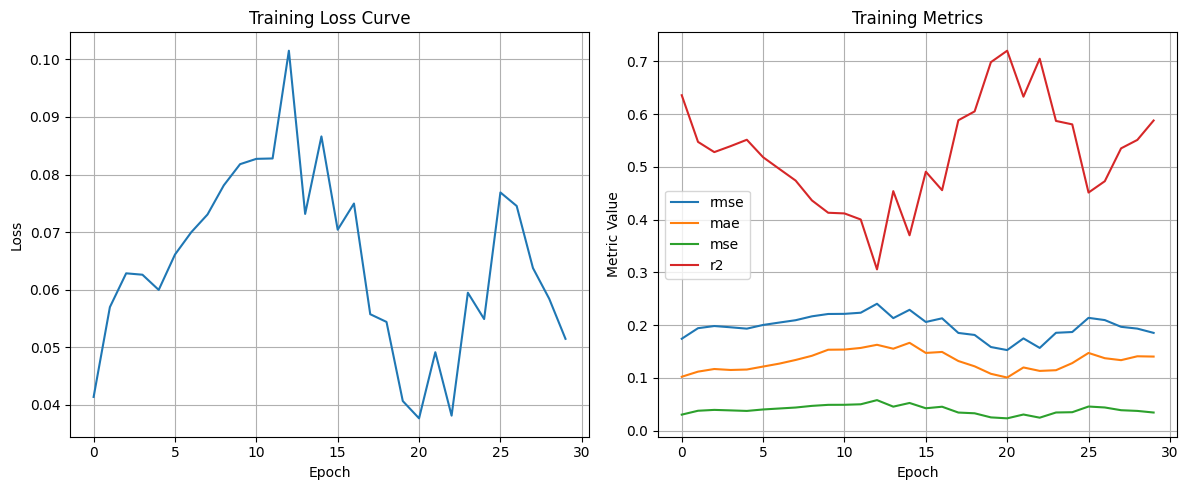

In [138]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [139]:
len(test_loader)

113

In [143]:
model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    # test_eps = []
    
    rul = torch.ones((len(test_loader),)).to(device)

    with torch.no_grad():
        for i, (data, labels) in enumerate(tqdm(test_loader)):
            time_frac = torch.linspace(0, 1, steps=labels.shape[0]).unsqueeze(1).to(device)
            data = data.to(device)
            labels = labels.to(device)
            # print(time_frac.shape, "SHAPE X", data.shape)
            predictions = model(data).flatten()
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))
        # test_eps.append(early_prediction_score(test_targets, test_preds))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [144]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 113/113 [00:00<00:00, 206.97it/s]


{'test_r2': [-1.0219521376528684],
 'test_mae': [0.2472288],
 'test_mse': [0.09690058],
 'test_rmse': [0.3112886],
 'test_preds': array([0.3483485 , 0.38082814, 0.37881064, ..., 0.08103932, 0.07857196,
        0.10913455], dtype=float32),
 'test_targets': array([[0.99962103],
        [0.9994105 ],
        [0.9992    ],
        ...,
        [0.24190493],
        [0.24169439],
        [0.24148385]], dtype=float32)}

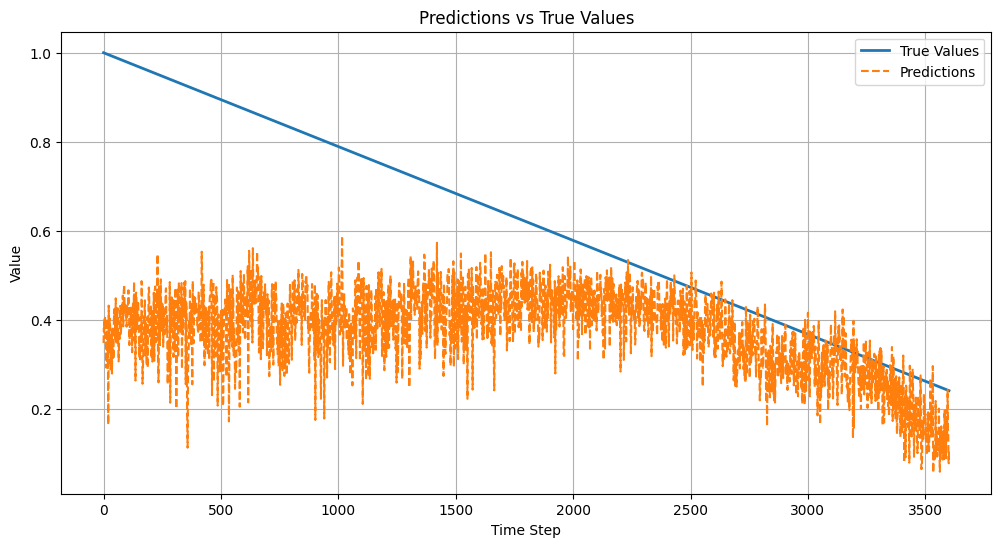

In [146]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds']
)

In [ ]:
test_results['test_targets']

(4602, 1)

In [300]:
test_results['test_preds']

array([0.02777791, 0.02777791, 0.02777791, ..., 0.02777791, 0.02777791,
       0.02777791], dtype=float32)

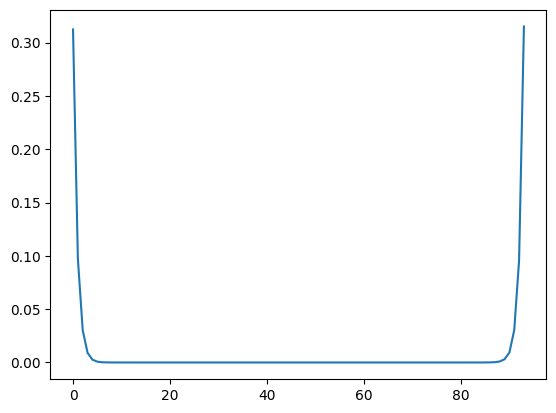

In [151]:
plt.plot(test_results['rul'].cpu().numpy())